In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

In [165]:
df = pd.read_csv("../data/AirPassengers.csv")
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
original_series = TimeSeries.from_dataframe(df, time_col="Month", value_cols="#Passengers")
len(original_series)

144

(True, np.int64(12))

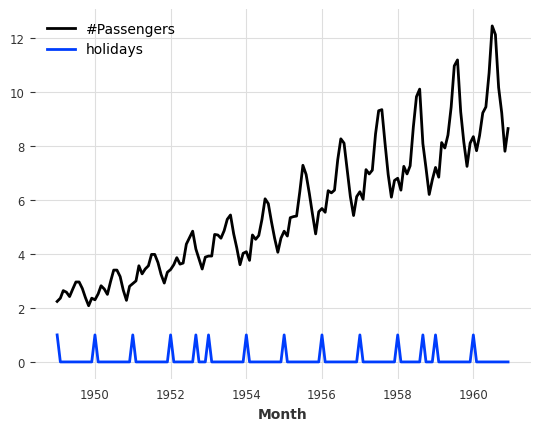

In [4]:
from darts.utils.statistics import check_seasonality

(original_series/50).add_holidays("US").plot()
check_seasonality(original_series)

In [5]:
# adjusting values dividing by the number of days in each month

adjusted_values = []
for data_point in original_series:
    days_in_month = data_point.time_index[0].days_in_month
    adjusted_values.append(data_point.values()[0][0]/days_in_month)

adjusted_series = TimeSeries.from_times_and_values(original_series.time_index, adjusted_values)

Text(0.5, 1.0, 'Adjusted series')

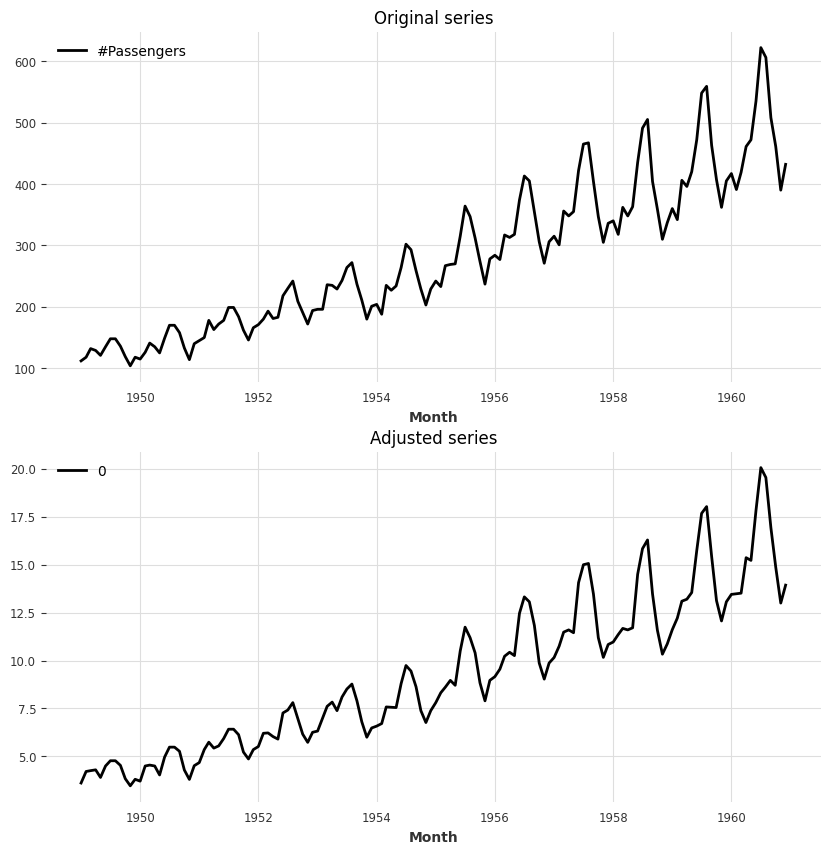

In [6]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
original_series.plot()
plt.title("Original series")

plt.subplot(2,1,2)
adjusted_series.plot()
plt.title("Adjusted series")


<Axes: xlabel='Month'>

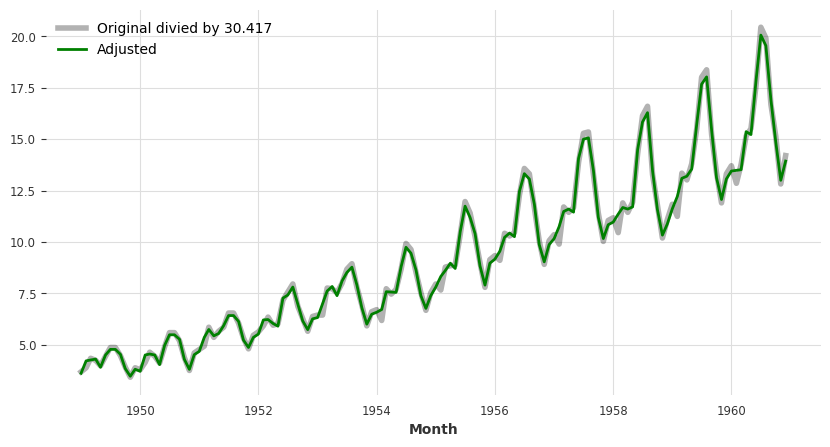

In [158]:
plt.figure(figsize=(10,5))

(original_series/30.417).plot(label="Original divied by 30.417", alpha=0.3, lw=4)

adjusted_series.plot(label="Adjusted", color="green")

In [8]:
#series = original_series
series = adjusted_series

train, val = series.split_after(0.8)

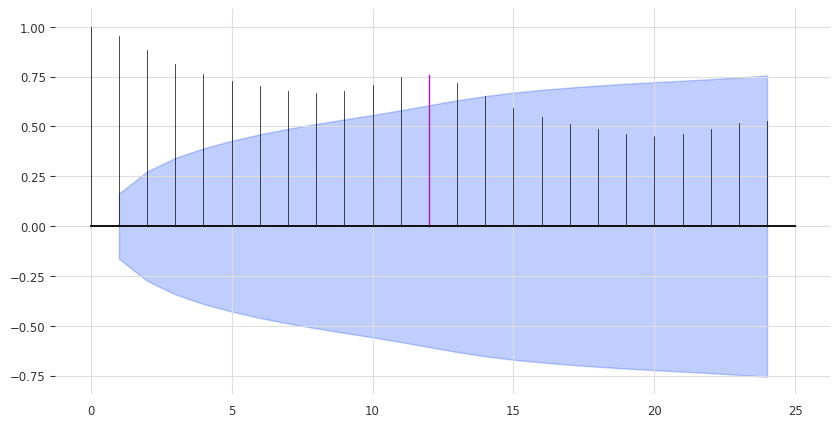

In [9]:
from darts.utils.statistics import plot_acf

plot_acf(series, m=12, max_lag=24)

<h3>Hand made models</h3>

Mean Absolute Percentage Error: 18.56%.


<Axes: xlabel='Month'>

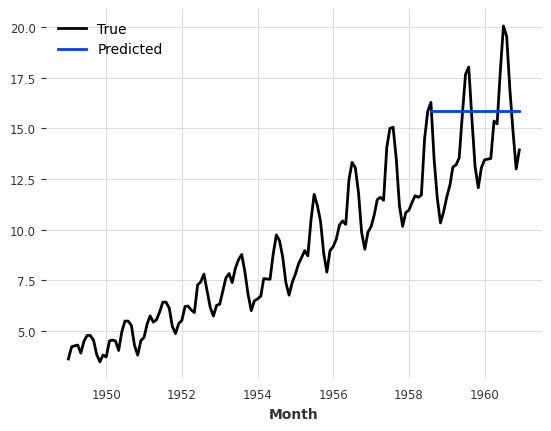

In [11]:
from darts.metrics import mape

time_indices = val.time_index
#naive_values = np.full(len(time_indices), train.values()[-1])
naive_values = [train.values()[-1]]*len(time_indices)
pred_naive = TimeSeries.from_times_and_values(time_indices, naive_values)

print(f"Mean Absolute Percentage Error: {mape(val, pred_naive):.2f}%.")
series.plot(label="True")
pred_naive.plot(label="Predicted")

Mean Absolute Percentage Error: 43.84%.


<Axes: xlabel='Month'>

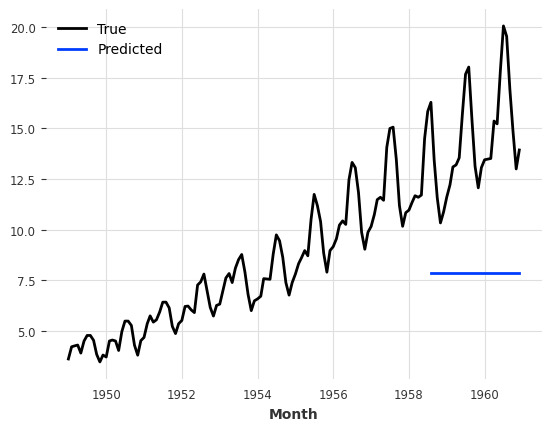

In [12]:
train_values = train.values()
mean_value = sum(train_values)/len(train_values)
time_indices = val.time_index
mean_values = np.full(len(time_indices), mean_value)
mean_series = TimeSeries.from_times_and_values(time_indices, mean_values)

print(f"Mean Absolute Percentage Error: {mape(val, mean_series):.2f}%.")
series.plot(label="True")
mean_series.plot(label="Predicted")

<h3>Darts Models</h3>

In [159]:
def fit_and_show_forecast(model, probabilistic=True):
    model.fit(train)
    if probabilistic:
        pred = model.predict(len(val), num_samples=500)
    else:
        pred = model.predict(len(val))

    residuals = model.residuals(train)
    residuals_mean = sum(residuals.values())/len(residuals.values())
    
    series.plot(label="True")
    pred.plot(label="Predicted: "+model.__class__.__name__)
    (pred+residuals_mean).plot(label="Bias corrected: "+model.__class__.__name__)
    residuals.plot(label="Residuals")

    print(f"Mean Absolute Percentage Error: {mape(val, pred):.2f}%.")
    print(f"Mean Absolute Percentage Error (Bias adjusted): {mape(val, pred+residuals_mean):.2f}%.")
    
    return pred



# --------- some old funcions
"""
def plot_bias_adjusted(observed, pred):
    residuals = observed - pred
    residuals_mean = sum(residuals.values())/len(residuals)
    pred_no_bias = pred + residuals_mean
    
    print(f"Mean Absolute Percentage Error: {mape(observed, pred_no_bias):.2f}%.")
    
    series.plot(label="True")
    pred_no_bias.plot(label="Bias corrected prediction", color="forestgreen")
    #plot_acf(residuals, m=5, alpha=0.05, max_lag=10)

def residual_mean(model):
    residual_array = model.residuals(val).values()
    residual_array_mean = sum(residual_array)/len(residual_array)
    return residual_array_mean

def plot_bias_adjusted(model, pred):
    r_mean = residual_mean(model)
    pred_no_bias = pred + r_mean
    series.plot()
    pred_no_bias.plot()
"""


'\ndef plot_bias_adjusted(observed, pred):\n    residuals = observed - pred\n    residuals_mean = sum(residuals.values())/len(residuals)\n    pred_no_bias = pred + residuals_mean\n    \n    print(f"Mean Absolute Percentage Error: {mape(observed, pred_no_bias):.2f}%.")\n    \n    series.plot(label="True")\n    pred_no_bias.plot(label="Bias corrected prediction", color="forestgreen")\n    #plot_acf(residuals, m=5, alpha=0.05, max_lag=10)\n\ndef residual_mean(model):\n    residual_array = model.residuals(val).values()\n    residual_array_mean = sum(residual_array)/len(residual_array)\n    return residual_array_mean\n\ndef plot_bias_adjusted(model, pred):\n    r_mean = residual_mean(model)\n    pred_no_bias = pred + r_mean\n    series.plot()\n    pred_no_bias.plot()\n'

Mean Absolute Percentage Error: 25.38%.
Mean Absolute Percentage Error (Bias adjusted): 25.52%.


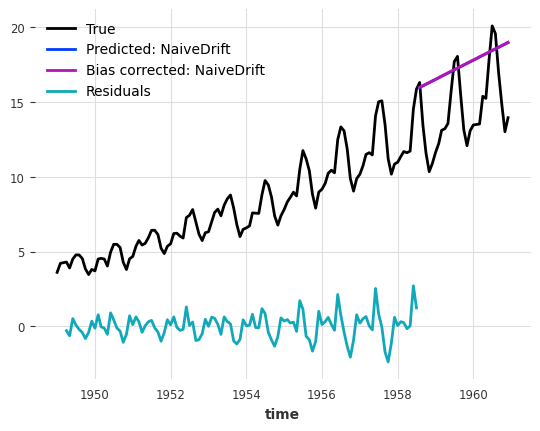

In [15]:
from darts.models import NaiveDrift

model_drift = NaiveDrift()
pred_drift = fit_and_show_forecast(model_drift, probabilistic=False)

Mean Absolute Percentage Error: 13.94%.
Mean Absolute Percentage Error (Bias adjusted): 9.31%.


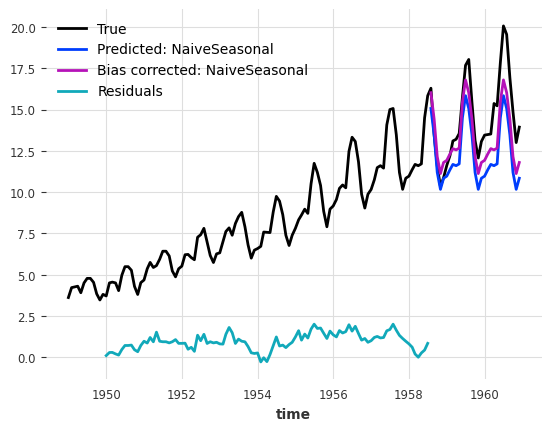

In [14]:
from darts.models import NaiveSeasonal

model_naive_seasonal = NaiveSeasonal(K=12)
pred_naive_seasonal = fit_and_show_forecast(model_naive_seasonal, probabilistic=False)

Mean Absolute Percentage Error: 4.30%.


<Axes: xlabel='Month'>

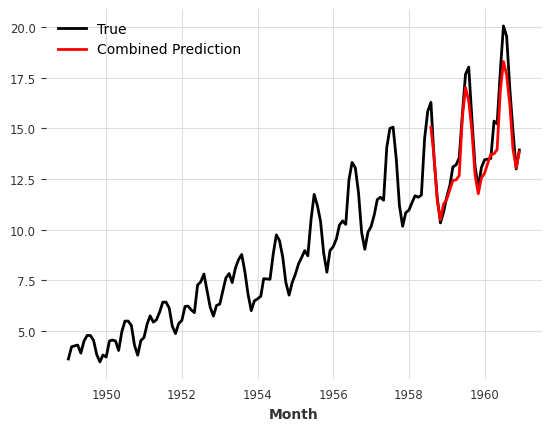

In [160]:
pred_combined = pred_naive_seasonal + (pred_drift-pred_drift[0])
print(f"Mean Absolute Percentage Error: {mape(series, pred_combined):.2f}%.")
series.plot(label="True")
pred_combined.plot(label="Combined Prediction", color="red")

Mean Absolute Percentage Error: 11.40%.
Mean Absolute Percentage Error (Bias adjusted): 11.75%.


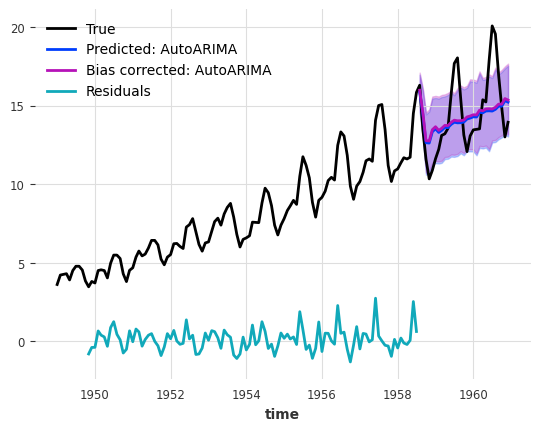

In [17]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
pred_aarima = fit_and_show_forecast(model_aarima)

Mean Absolute Percentage Error: 6.53%.
Mean Absolute Percentage Error (Bias adjusted): 6.42%.


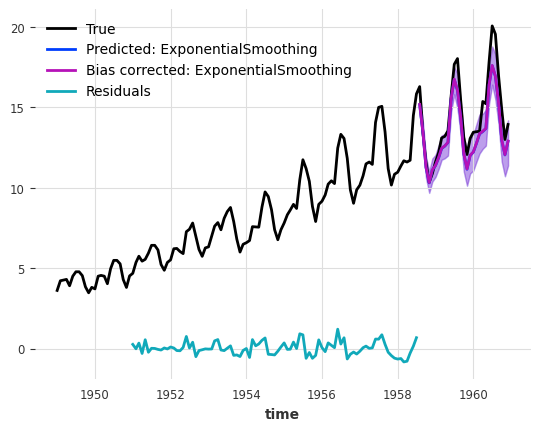

In [18]:
from darts.models import ExponentialSmoothing

model_ES = ExponentialSmoothing()
pred_ES = fit_and_show_forecast(model_ES)

<h3>Backtesting</h3>

In [19]:
models = [ExponentialSmoothing(), NaiveSeasonal(K=12)]
#models = [NaiveDrift()]
backtests = [model.historical_forecasts(series,
                            start=.5,
                            forecast_horizon=3)
             for model in models]

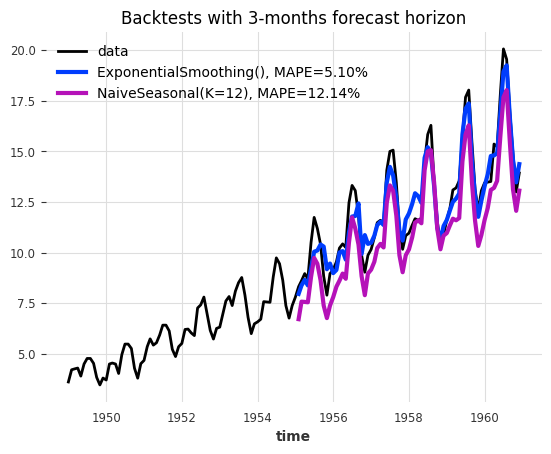

In [20]:
series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))
plt.title('Backtests with 3-months forecast horizon')
plt.legend()

<h3>Residual Analysis</h3>

In [21]:
residuals_ES = model_ES.residuals(train)

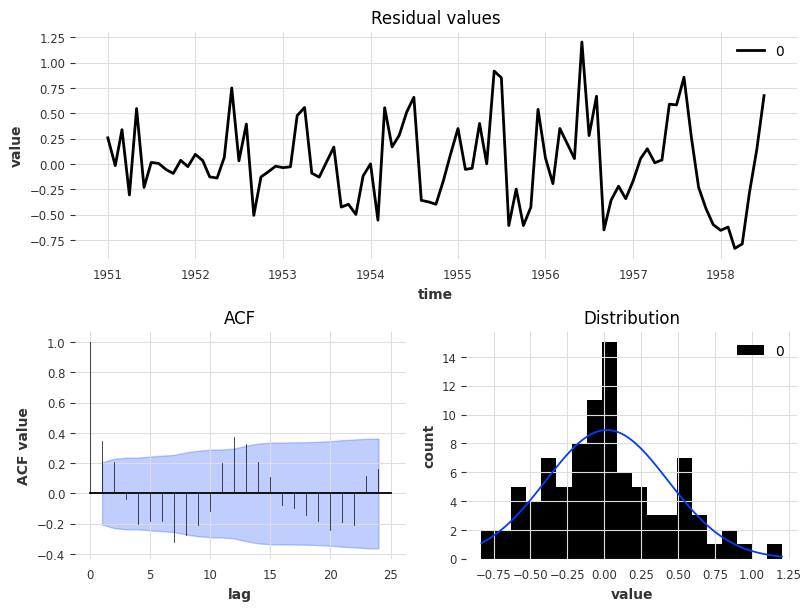

In [22]:
from darts.utils.statistics import plot_residuals_analysis
plot_residuals_analysis(residuals_ES)

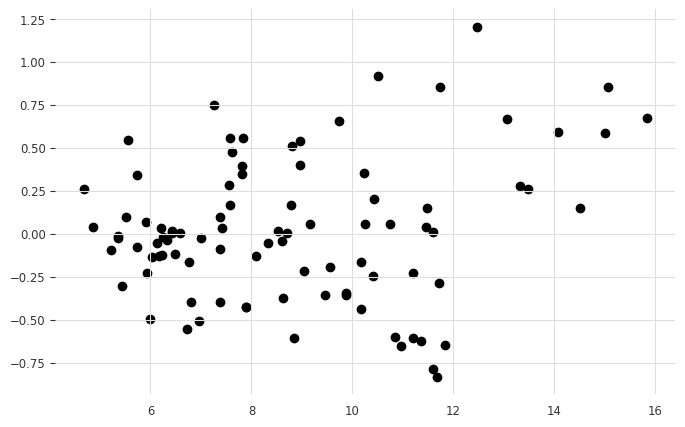

In [23]:
plt.figure(figsize=(8,5))
plt.scatter(train[residuals_ES.time_index].values() , residuals_ES.values())

plt.show()

<h3> Drift model residuals on SQRT time series </h3> 

In [161]:
df_temperatures = pd.read_csv("../data/temperature_SQRT.csv", delimiter=";", decimal=",", index_col=0)
series_temperatures = TimeSeries.from_dataframe(df_temperatures, time_col="year", value_cols="temp")
df_temperatures.head()

,year,temp
index,,
1,1,1.000000
2,2,1.189207
3,3,1.316074
4,4,1.414214
5,5,1.495349


<Axes: xlabel='year'>

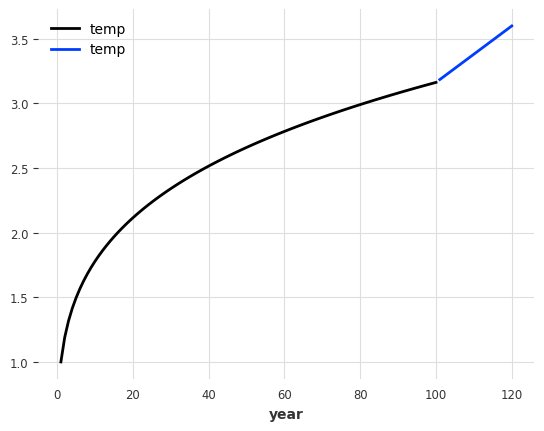

In [30]:
model_drift_temp = NaiveDrift()
model_drift_temp.fit(series_temperatures)
pred_temp = model_drift_temp.predict(20)
res_temp = model_drift_temp.residuals(series_temperatures)

series_temperatures.plot()
pred_temp.plot()

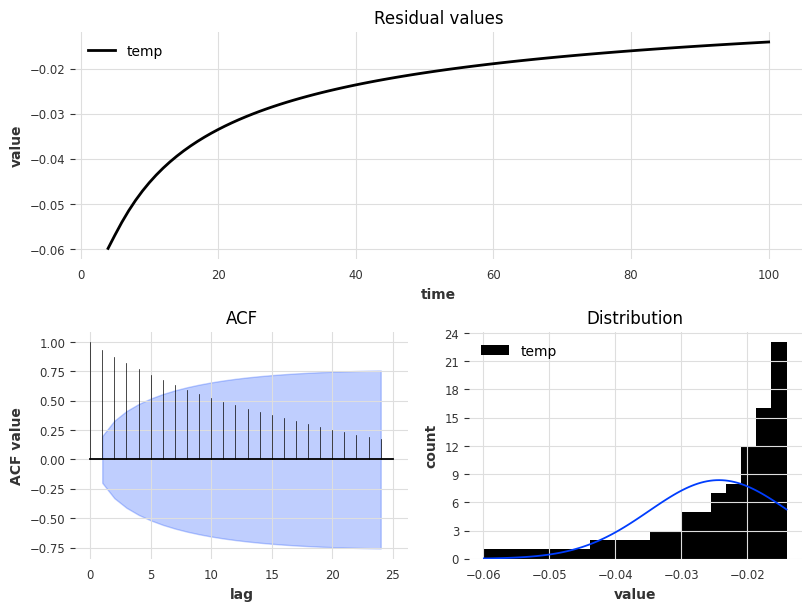

In [27]:
plot_residuals_analysis(res_temp)

In [33]:
residuals_temp_mean = res_temp.values().mean()
print(f"Residuals Mean: {residuals_temp_mean:.5f}")

Residuals Mean: -0.02429


<Axes: xlabel='year'>

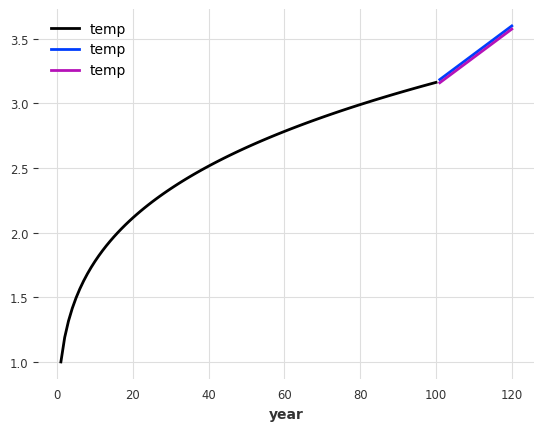

In [34]:
series_temperatures.plot()
pred_temp.plot()
(pred_temp + residuals_temp_mean).plot()

<h3> Simple Linear Regression </h3>

In [62]:
def get_regression_params(X,Y):
    meanX = sum(X)/len(X)
    meanY = sum(Y)/len(Y)

    num = 0
    den = 0
    
    for x, y in zip(X,Y):
        num += (x - meanX) * (y - meanY)
        den += (x - meanX)*(x - meanX)

    a = num/den
    b = meanY - a*meanX

    return (a,b)

def show_regression(X,Y):
    plt.scatter(X,Y, label="Points")
    plt.axline(label="Regression", slope=a, xy1=(0,b), color="red")
    
    meanX = sum(X)/len(X)
    meanY = sum(Y)/len(Y)
    
    plt.axline(label="meanY", slope=0, xy1=(0, meanY), color="blue",linestyle="--")
    plt.axvline(label="meanX", x=meanX, color="blue", linestyle="--")
    
    plt.legend()

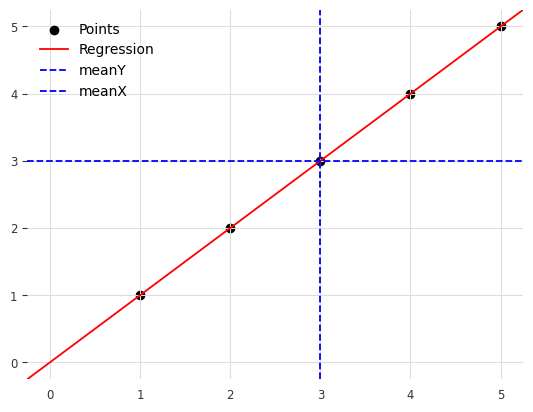

In [63]:
X = [1,2,3,4,5]
Y = [1,2,3,4,5]
#Y = [1,1,1,7,1]
#Y = [1,2,1,2,1]

a, b = get_regression_params(X,Y)

show_regression(X,Y)

In [37]:
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

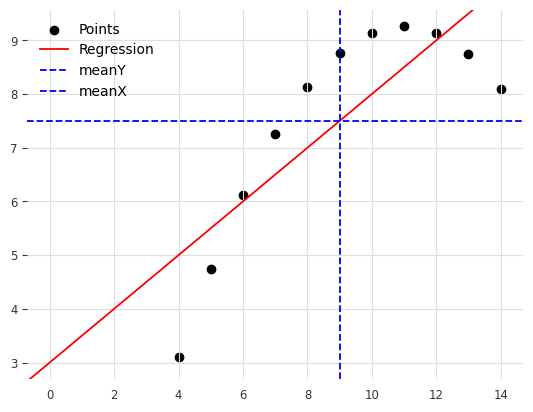

In [162]:
X = x
Y = y2

a, b = get_regression_params(X,Y)

show_regression(X,Y)

<h3>Series decomposition</h3>

<Axes: xlabel='Month'>

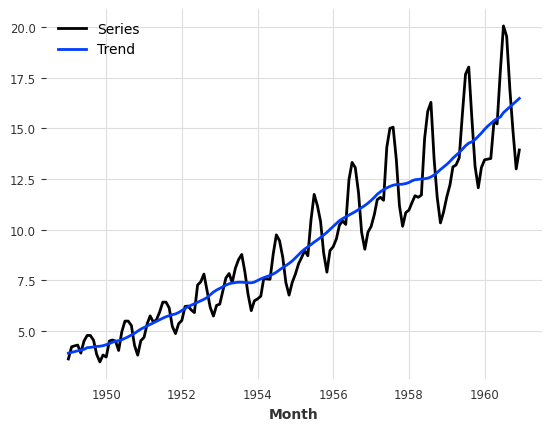

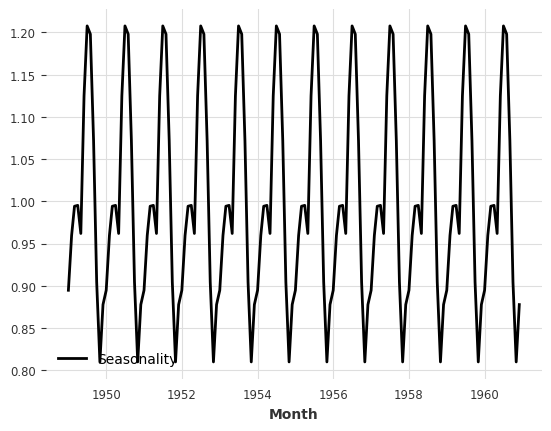

In [114]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

trend, seasonality = extract_trend_and_seasonality(series, model=ModelMode.MULTIPLICATIVE)

plt.subplots()
series.plot(label="Series")
trend.plot(label="Trend")

plt.subplots()
seasonality.plot(label="Seasonality")

<Axes: xlabel='Month'>

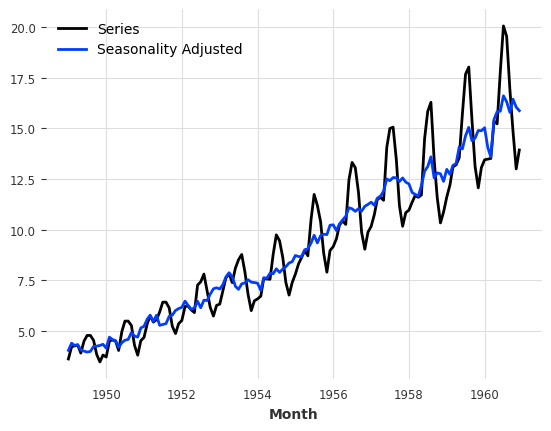

In [119]:
series.plot(label="Series")
(series/seasonality).plot(label="Seasonality Adjusted")

<Axes: xlabel='Month'>

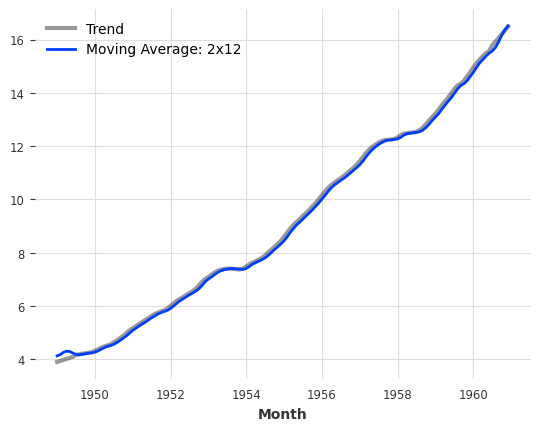

In [155]:
from darts.models.filtering.moving_average_filter import MovingAverageFilter

ma = MovingAverageFilter(12)
trend.plot(label="Trend", alpha=0.4, lw=3)
series_ma12 = ma.filter(series)

ma = MovingAverageFilter(2)
ma.filter(series_ma12).plot(label=f"Moving Average: 2x12")

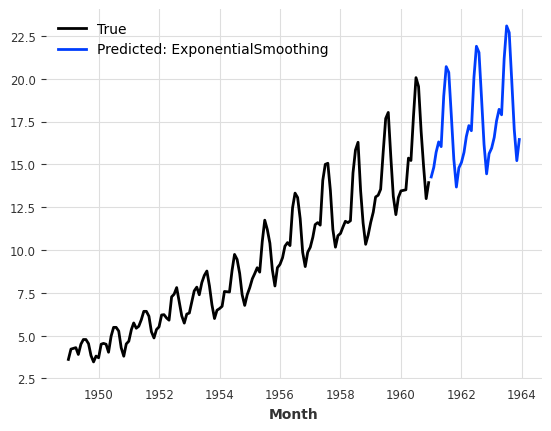

In [389]:
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

def test(model, series=series):
    model.fit(series)
    pred = model.predict(36)
    
    series.plot(label="True")
    pred.plot(label="Predicted: "+model.__class__.__name__)

mm = ExponentialSmoothing(
    seasonal_periods=12,
    seasonal=SeasonalityMode.MULTIPLICATIVE,
    trend=ModelMode.ADDITIVE,
    #damped=True,
    smoothing_level=0.8,
    smoothing_trend=0.001,
    smoothing_seasonal=0.15
)
test(mm)

142

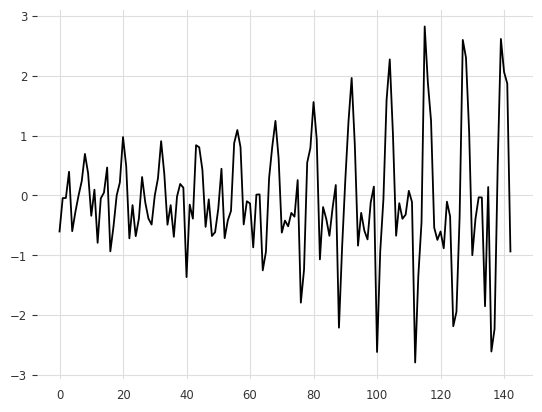

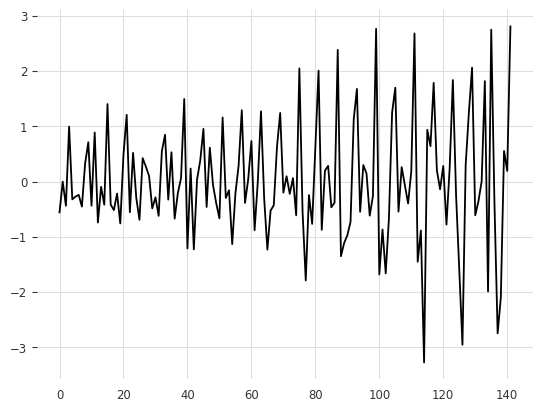

In [343]:
import inspect

def series_differencing(series):
    if isinstance(series, TimeSeries):
        yn = series.values().flatten()
        yn_1 = series.values().flatten()
    else:
        yn = series
        yn_1 = series
    
    yn = np.append(0, yn)
    yn_1 = np.append(yn_1, 0)
    diff = yn-yn_1
    diff = np.delete(diff, 0)
    diff = np.delete(diff, -1)

    plt.subplots()
    plt.plot(diff)
    
    return diff

diff = series_differencing(series)
diff_2 = series_differencing(diff)
len(diff_2)


<Axes: xlabel='Month'>

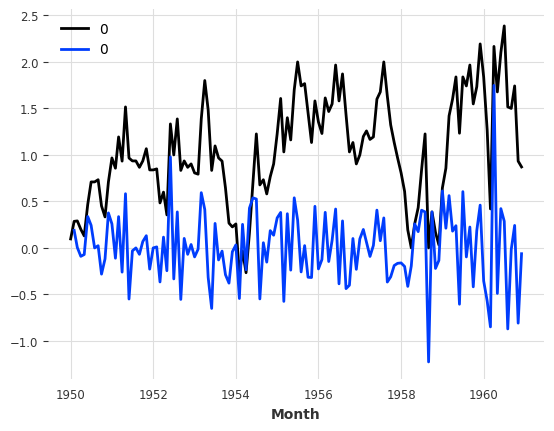

In [350]:
from darts.dataprocessing.transformers.diff import Diff

diff_one = Diff(lags = 1)
series_diff_one = diff_one.fit_transform(series)

diff_year = Diff(lags = 12)
series_diff_year = diff_year.fit_transform(series)
series_diff_year.plot()

series_diff_year_diff = diff_one.fit_transform(series_diff_year)
series_diff_year_diff.plot()

In [397]:
from darts.utils.statistics import stationarity_test_kpss as kpss

kpss(ts=series_diff_year)

(np.float64(0.5293360574324585),
 np.float64(0.03505944652422106),
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

C:\Users\marko\Desktop\darts-test\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


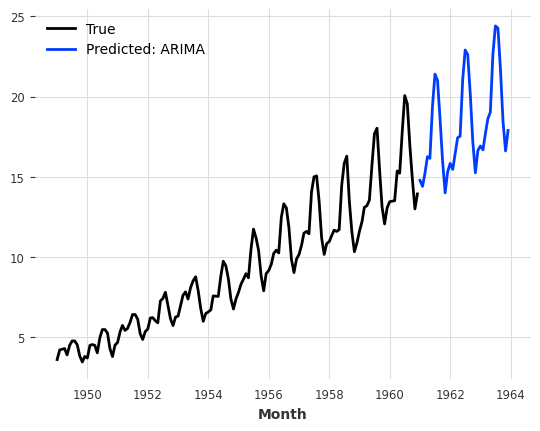

In [437]:
from darts.models.forecasting.arima import ARIMA

test(ARIMA(p=12, d=1, q=2, seasonal_order=[0,1,2,12]), series)

C:\Users\marko\Desktop\darts-test\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marko\Desktop\darts-test\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Month'>

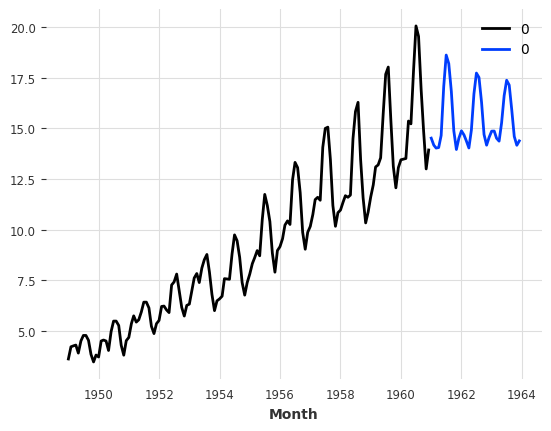

In [409]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
future_cov = datetime_attribute_timeseries(series, "month", cyclic=True, add_length=36)
model = ARIMA(p=12, d=0, q=0)
model.fit(series, future_covariates=future_cov)
pred = model.predict(36, future_covariates=future_cov)

series.plot()
pred.plot()